In [61]:
import pandas as pd
import random
import numpy as np
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,make_scorer,log_loss,roc_curve
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [74]:
file = '/Users/janmichaelaustria/Google Drive/Insight 2020/Sepsis Detection/24hr_windows_sep_only.csv'
sepsis = pd.read_csv(file, index_col=0)

/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [99]:
sepsis = sepsis.sample(frac=1)
X = sepsis.iloc[:,2:-2]
y = sepsis['SepsisLabel']
del sepsis

In [10]:
features = list(X.columns)
features

['Hours',
 'HR',
 'O2Sat',
 'Temp',
 'SBP',
 'MAP',
 'DBP',
 'Resp',
 'EtCO2',
 'BaseExcess',
 'HCO3',
 'FiO2',
 'pH',
 'PaCO2',
 'SaO2',
 'AST',
 'BUN',
 'Alkalinephos',
 'Calcium',
 'Chloride',
 'Creatinine',
 'Bilirubin_direct',
 'Glucose',
 'Lactate',
 'Magnesium',
 'Phosphate',
 'Potassium',
 'Bilirubin_total',
 'TroponinI',
 'Hct',
 'Hgb',
 'PTT',
 'WBC',
 'Fibrinogen',
 'Platelets',
 'Age',
 'Gender',
 'Unit1',
 'Unit2',
 'HospAdmTime',
 'ICULOS']

In [11]:
xgb_model = xgb.XGBClassifier()
parameters = {'objective':['binary:logistic'],
              'max_depth': [9],
              'n_estimators': [500]}
scoring = {'f1': make_scorer(f1_score), 
           'Accuracy': make_scorer(accuracy_score),
          'precision': make_scorer(precision_score),
          'recall':make_scorer(recall_score),
          'auc':make_scorer(roc_auc_score)}

kfold = StratifiedKFold(n_splits=3, shuffle=True)
clf = GridSearchCV(xgb_model, parameters, n_jobs=-1, 
                   cv=kfold, 
                   scoring=scoring,
                   verbose=3, refit='auc')
clf.fit(X,y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 120.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:l...
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [9], 'n_estimators': [500],
                         'objective': ['binary:logistic']},
             pre_dispatch='2*n_jobs', refit='auc', return_train_score=False,
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'auc': make_scorer(roc_auc_score),
               

In [36]:
pd.DataFrame(clf.cv_results_).to_csv('XGboost_V2_metrics.csv')

In [37]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_objective,params,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_test_precision,split1_test_precision,split2_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_auc,split1_test_auc,split2_test_auc,mean_test_auc,std_test_auc,rank_test_auc
0,7145.200148,12.475851,47.619113,2.282165,9,500,binary:logistic,"{'max_depth': 9, 'n_estimators': 500, 'objecti...",0.983207,0.986027,0.985188,0.984807,0.001182,1,0.999115,0.999262,0.999218,0.999198,0.000062,1,0.996916,0.997728,0.997346,0.99733,0.000332,1,0.96987,0.974597,0.973323,0.972597,0.001997,1,0.984894,0.987268,0.986626,0.986263,0.001003,1


In [100]:
###geneate random numbers to pull samples from
samples = random.sample(range(X.shape[0]), 100000)

In [101]:
probas = clf.best_estimator_.predict_proba(X.iloc[samples,:])[:,0]

In [57]:
len(probas)

100000

In [69]:
fpr, tpr, thresholds = roc_curve(y[samples], probas)

Text(0, 0.5, 'TPR')

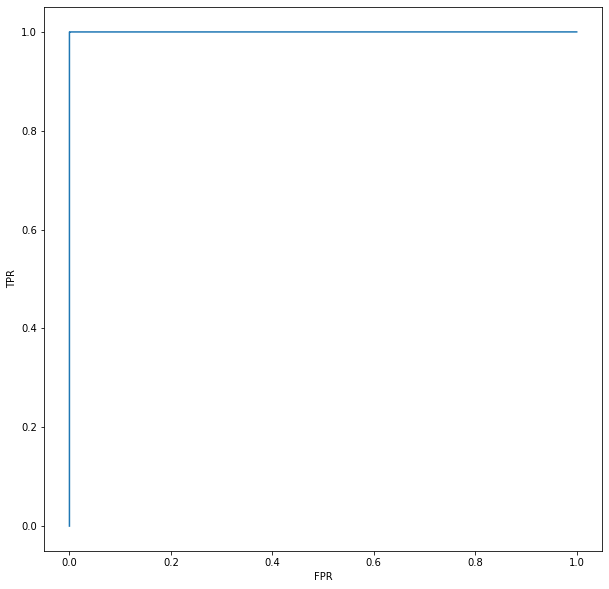

In [70]:
plt.figure(figsize=(10,10))
plt.plot(tpr,fpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

### Lets examine this with a particular patient

In [83]:
test = sepsis[sepsis['PatientID_Part'].str.contains('p000009')].iloc[-24:-1,:]

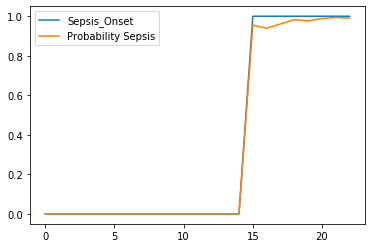

In [97]:
labels = test['SepsisLabel']
x_s = test.iloc[:,2:-2]
probs = clf.predict_proba(x_s)[:,1]
plt.plot(range(0,23),labels,label='Sepsis_Onset')
plt.plot(range(0,23),probs,label='Probability Sepsis')
plt.legend()
plt.show()

In [23]:
clf.best_estimator_.feature_importances_

array([0.539324  , 0.00705142, 0.0061625 , 0.00985951, 0.00572594,
       0.00549849, 0.00703547, 0.00644849, 0.01026929, 0.01071043,
       0.01293395, 0.01052289, 0.01136658, 0.01018325, 0.01090053,
       0.01225416, 0.01267247, 0.01237721, 0.0163825 , 0.01211327,
       0.01196334, 0.01462002, 0.00945787, 0.01130529, 0.02014978,
       0.01282829, 0.0120774 , 0.01430927, 0.01320566, 0.00978756,
       0.01258416, 0.01209794, 0.01225414, 0.01406584, 0.01176779,
       0.0136929 , 0.0118979 , 0.01629698, 0.01208543, 0.0135354 ,
       0.0102247 ], dtype=float32)

In [26]:
feats_frame = pd.DataFrame()
feats_frame['Features'] = features
feats_frame['Scores'] = clf.best_estimator_.feature_importances_
feats_frame.sort_values('Scores',ascending=False)

,Features,Scores
0,Hours,0.539324
24,Magnesium,0.020150
18,Calcium,0.016382
37,Unit1,0.016297
21,Bilirubin_direct,0.014620
27,Bilirubin_total,0.014309
33,Fibrinogen,0.014066
35,Age,0.013693
39,HospAdmTime,0.013535
28,TroponinI,0.013206


In [38]:
feats_frame.to_csv("XGBOOST_v2_feat_import.csv")

In [35]:
import pickle
pickle.dump(clf.best_estimator_, open('xg_boost_v2.sav', 'wb'))

In [33]:
(np.sqrt(1+.00001) - 1) / .00001

0.4999987500031721

In [73]:
del X,y

AUC probability that randomly chosen negative class has a higher probability of being negative than a randomly chose positive class

Precision and recall curve

In [98]:
from sklearn.metrics import precision_recall_curve

In [102]:
precision, recall, thresholds = precision_recall_curve(y[samples], probas)

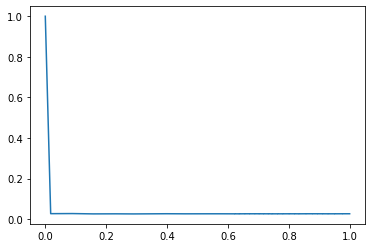

In [103]:
plt.plot(recall,precision)